In [0]:
"""
From Appendix B in the paper
Implementation of autograd
"""

import scipy.integrate

import autograd.numpy as np
from autograd.extend import primitive, defvjp_argnums
from autograd import make_vjp
from autograd.misc import flatten
from autograd.builtins import tuple


In [27]:

odeint = primitive(scipy.integrate.odeint)


def grad_odeint_all(yt, func, y0, t, func_args, **kwargs):
	"""
	Extended from "Scalable Inference of Ordinary Differential"
	Equation Models of Biochemical Processes". Sec. 2.4.2
	Fabian Froehlich, Carolin Loos, Jan Hasenauer, 2017
	https://arxiv.org/pdf/1711.08079.pdf
	"""

	T, D = np.shape(yt)
	flat_args, unflatten = flatten(func_args)

	def flat_func(y, t, flat_args):
		return func(y, t, *unflatten(flat_args))


	def unpack(x):
		#	   y, 		vjp_y,		vjp_t, 		vjp_args
		return x[0:D],	x[D:2 * D],	x[2 * D],	x[2 * D + 1:]


	def augmented_dynamics(augmented_state, t, flat_args):
		# Original system augemented with vjp_y, vjp_t and vjp_args
		y, vjp_y, _, _ = unpack(augmented_state)
		vjp_all, dy_dt = make_vjp(flat_func, argnum=(0, 1, 2))(y, t, flat_args)
		vjp_y, vjp_t, vjp_args = vjp_all(-vjp_y)
		return np.hstack((dy_dt, vjp_y, vjp_t, vjp_args))


	def vjp_all(g, **kwargs):
		vjp_y = g[-1, :]
		vjp_t0 = 0
		time_vjp_list = []
		vjp_args = np.zeros(np.size(flat_args))

		for i in range(T - 1, 0, -1):
			# Compute effect of moving current time.
			vjp_cur_t = np.dot(func(yt[i, :], t[i], *func_args), g[i, :])
			time_vjp_list.append(vjp_cur_t)
			vjp_t0 = vjp_t0 - vjp_cur_t

			# Run augmented system backwards to the previous observation
			aug_y0 = np.hstack((yt[i, :], vjp_y, vjp_t0, vjp_args))
			aug_ans = odeint(augmented_dynamics, aug_y0,
							 np.array(t[i], t[i - 1]), tuple((flat_args,)), **kwargs)
			_, vjp_y, vjp_t0, vjp_args = unpack(aug_ans[1])

			# Add gradient from current output
			vjp_y = vjp_y + g[i - 1, :]

		time_vjp_list.append(vjp_t0)
		vjp_times = np.hstack(time_vjp_list)[::-1]

		return None, vjp_y, vjp_times, unflatten(vjp_args)

	return vjp_all


def grad_argnums_wrapper(all_vjp_builder):
	"""
	A generic autograd helper funciton. Takes a function that
	builds vjps for all arguments, and wraps it to return only required vjps.
	"""
	def build_selected_vjps(argnums, ans, combined_args, kwargs):
		vjp_func = all_vjp_builder(ans, *combined_args, **kwargs)

		def chosen_vjps(g):
			# Return whichever vjps were asked for
			all_vjps = vjp_func(g)
			return [all_vjps[argnum] for argnum in argnums]

		return chosen_vjps

	return build_selected_vjps


if __name__ == '__main__':
	print(defvjp_argnums(odeint, grad_argnums_wrapper(grad_odeint_all)))


None


In [46]:
!git clone https://github.com/JSeam2/Neural-Ordinary-Differential-Equations

Cloning into 'Neural-Ordinary-Differential-Equations'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 54 (delta 12), reused 17 (delta 7), pack-reused 32
Unpacking objects: 100% (54/54), done.


In [47]:
#!rm Neural-Ordinary-Differential-Equations
!ls -Rt


.:
Neural-Ordinary-Differential-Equations	sample_data

./Neural-Ordinary-Differential-Equations:
 data.csv	    autograd_extended.py	       README.md
 requirements.txt  'Training Latent ODE Model.ipynb'

./sample_data:
mnist_test.csv	       california_housing_test.csv   anscombe.json
mnist_train_small.csv  california_housing_train.csv  README.md


In [0]:
# import
import numpy as np
import pandas as pd
#import autograd_extended
import tensorflow as tf
import matplotlib.pyplot as plt
#from .Neural-Ordinary-Differential-Equations import autograd_extend #won't work as the - is crap for python
from keras.models import Model
from keras.layers import LSTM, Input, Lambda, Dense, RepeatVector
from keras import backend as K
from keras import objectives


In [0]:

# obtain simple time series with sine function
df = pd.read_csv('Neural-Ordinary-Differential-Equations/data.csv')

x, y = df["x"], df["y"]

# split y into timesteps for training (-1, 100, 1) we use a sliding window
timesteps = 5

newY = []
for i in range(0, len(y)-timesteps):
    temp = y[i:i+timesteps]
    
    temp_ls = []
    for j in temp:
        temp_ls.append([j])
    newY.append(temp_ls)
    
y = np.array(newY)


In [58]:
# Run an RNN encoder on the time series

# Params
timesteps = 5
input_dim = 1
lstm_dim = 32
latent_dim = 100
batch_size = 1

# Encoder model
def sample_z(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# Input
inputs = Input(shape=(timesteps, input_dim,), name='encoder_input')

# LSTM encoding
h = LSTM(lstm_dim)(inputs)

# VAE Z layer
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

# Obtain z
z = Lambda(sample_z, output_shape=(latent_dim,))([z_mean, z_log_sigma])

encoder = Model(inputs, z_mean, name="encoder")

# Decoder model
decoder_h = LSTM(lstm_dim, return_sequences=True)
decoder_mean = LSTM(input_dim, return_sequences=True)

h_decoded = RepeatVector(timesteps)(z)
h_decoded = decoder_h(h_decoded)

# decoded layer
outputs = decoder_mean(h_decoded)

# decoder, from latent space to reconstructed inputs
decoder_inputs = Input(shape=(latent_dim,))

_h_decoded = RepeatVector(timesteps)(decoder_inputs)
_h_decoded = decoder_h(_h_decoded)

decoder_outputs = decoder_mean(_h_decoded)

decoder = Model(decoder_inputs, decoder_outputs)

# Build vae
vae = Model(inputs, outputs, name='vae_lstm')
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.mse(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
    loss = xent_loss + kl_loss
    return loss

vae.compile(optimizer='adam', loss=vae_loss)

encoder.summary()
decoder.summary()
vae.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 5, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3300      
Total params: 7,652
Trainable params: 7,652
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 5, 100)            0         
_________________________________________________________________
lstm_2 (

In [59]:
# Train the VAE to obtain z
vae.fit(y, y, epochs=20)

Epoch 1/20
1995/1995 [==============================] - 4s 2ms/step - loss: 0.5028
Epoch 2/20
1995/1995 [==============================] - 1s 516us/step - loss: 0.4741
Epoch 3/20
1995/1995 [==============================] - 1s 488us/step - loss: 0.4632
Epoch 4/20
1995/1995 [==============================] - 1s 482us/step - loss: 0.4574
Epoch 5/20
1995/1995 [==============================] - 1s 477us/step - loss: 0.4411
Epoch 6/20
1995/1995 [==============================] - 1s 482us/step - loss: 0.3516
Epoch 7/20
1995/1995 [==============================] - 1s 482us/step - loss: 0.2443
Epoch 8/20
1995/1995 [==============================] - 1s 487us/step - loss: 0.2134
Epoch 9/20
1995/1995 [==============================] - 1s 482us/step - loss: 0.1960
Epoch 10/20
1995/1995 [==============================] - 1s 475us/step - loss: 0.1847
Epoch 11/20
1995/1995 [==============================] - 1s 475us/step - loss: 0.1749
Epoch 12/20
1995/1995 [==============================] - 1s 480us

x: (1995, 5, 1), preds: (1995, 5, 1)


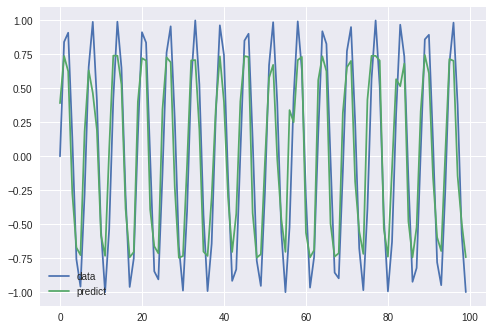

In [60]:
# Sanity check, we should get a sine graph
prediction = vae.predict(y, batch_size=batch_size)

# pick a column to plot.
print("x: %s, preds: %s" % (y.shape, prediction.shape))
plt.plot(y[:100,0,0], label='data')
plt.plot(prediction[:100,0,0], label='predict')
plt.legend()
plt.show()
